In [31]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import date

class TwoStarELS:
    def __init__(self, 
                 first_star, 
                 second_star, 
                 a_day_before_starting_date, 
                 starting_date,
                 checking_date,
                 strike_price, 
                 coupon_rate, 
                 knock_in_barrier,
                 riskfree_rate=0.015):
        
        self.first_star_raw = first_star
        self.second_star_raw = second_star
        self.a_day_before_starting_date = a_day_before_starting_date
        self.starting_date = starting_date
        self.checking_date = checking_date
        self.strike_price = strike_price
        self.coupon_rate = coupon_rate
        self.knock_in_barrier = knock_in_barrier
        self.riskfree_rate = riskfree_rate
        self.investment_amount = 100000000
    
    
    def run(self, n_simulation=1000, preprocessing_verbose=False, simulation_verbose=False, firm_list=["A", "B"]):
        self._preprocess(verbose=preprocessing_verbose)
        self.MCMC(n_simulation=n_simulation, verbose=simulation_verbose, firm_list=firm_list)
        self.compute_value()
        
    
    def _preprocess(self, verbose=False):
        self.first_star_s0 = self.first_star_raw[starting_date]
        self.second_star_s0 = self.second_star_raw[starting_date]
        self.s0 = np.array([self.first_star_s0, self.second_star_s0])
        
        self.first_star_profit_rate = self.first_star_raw[:a_day_before_starting_date].pct_change()
        self.second_star_profit_rate = self.second_star_raw[:a_day_before_starting_date].pct_change()
        
        if verbose:
            plt.title("Histogram of the profit rate")
            self.first_star_profit_rate.hist(bins=20, alpha=0.5)
            self.second_star_profit_rate.hist(bins=20, alpha=0.5)
        
        self.first_star_volatility = self.first_star_profit_rate.std()
        self.second_star_volatility = self.second_star_profit_rate.std()
        
        self.first_star_annualized_volatiliy = self.first_star_volatility * math.sqrt(252)
        self.second_star_annualized_volatiliy = self.second_star_volatility * math.sqrt(252)
        
        self.corrcoef = np.corrcoef(self.first_star_profit_rate[1:], self.second_star_profit_rate[1:])
        self.k_mat = np.linalg.cholesky(self.corrcoef)
    
    
    def MCMC(self, n_simulation=1000, simulation_duration=780, verbose=False, firm_list=["A", "B"]):
        self.episodes = []
        
        for i in tqdm(range(n_simulation)):
            episode = self.generate_episode(simulation_duration=simulation_duration)
            self.episodes.append(episode)
    
        if verbose:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            fig.suptitle(f"Simulated stock price of {firm_list[0]} & {firm_list[1]}", fontsize=16)

            for episode in self.episodes:
                ax1.plot(episode[0, :])
                ax2.plot(episode[1, :])

            ax1.set_title(f"{firm_list[0]}")
            ax2.set_title(f"{firm_list[1]}")

            fig.tight_layout()
            fig.subplots_adjust(top=0.8)

            plt.show()
    
    
    def generate_episode(self, simulation_duration, delta_t=1/252):
        first_star_episode = []
        second_star_episode = []

        first_star_price = self.first_star_s0
        second_star_price = self.second_star_s0

        w0 = np.random.normal(0, 1, [simulation_duration, 2]).T
        w = np.matmul(self.k_mat, w0)

        first_star_random_walk = np.exp((self.riskfree_rate - 0.5 * self.first_star_annualized_volatiliy ** 2) * delta_t + self.first_star_annualized_volatiliy * w[0, :] * np.sqrt(delta_t))
        second_star_random_walk = np.exp((self.riskfree_rate - 0.5 * self.second_star_annualized_volatiliy ** 2) * delta_t + self.second_star_annualized_volatiliy * w[1, :] * np.sqrt(delta_t))

        for i in range(simulation_duration):
            first_star_price *= first_star_random_walk[i]
            second_star_price *= second_star_random_walk[i]

            first_star_episode.append(first_star_price)
            second_star_episode.append(second_star_price)

        episode = np.vstack([first_star_episode, second_star_episode])

        return np.round(episode)

    
    def compute_value(self):
        d_list = []
        self.starting_date = pd.to_datetime(self.starting_date, format = "%Y/%m/%d").date()
        
        for date in self.checking_date:
            d = pd.to_datetime(date, format = "%Y/%m/%d").date()
            d_list.append(d)
        
        bussiness_date_distance = []
        for date in d_list:
            bussiness_date_distance.append(np.busday_count(self.starting_date, date))

        self.bussiness_date_distance = np.array(bussiness_date_distance)
        
        success_event = np.array([0, 0, 0, 0, 0, 0, 0])
        failure_event = np.array([0])

        discounted_pay_off = 0

        for episode in tqdm(self.episodes):
            is_payoff = False
            for i in range(len(strike_price)):
                performance = np.divide(episode[:, self.bussiness_date_distance], np.repeat(np.array([self.first_star_s0, self.second_star_s0]), len(self.strike_price)).reshape(2, -1))
                worst_performance = np.min(performance, axis=0)
                worst_performance_index = np.where(performance == worst_performance)[0]
                
                if worst_performance[i] >= strike_price[i]:
                    success_event[i] += 1
                    discounted_pay_off += np.sum(self.investment_amount * (1 + self.coupon_rate[i])) * np.exp(-self.riskfree_rate * self.bussiness_date_distance[i] / 252)
                    is_payoff = True
                    break
                    
            if worst_performance[i] > knock_in_barrier and is_payoff == False:
                success_event[-1] += 1
                discounted_pay_off += np.sum(self.investment_amount * (1 + self.coupon_rate[-1])) * np.exp(-self.riskfree_rate * self.bussiness_date_distance[-1] / 252)
            elif worst_performance[i] <= knock_in_barrier and is_payoff == False:
                failure_event += 1
                discounted_pay_off += (self.investment_amount * worst_performance[-1] / self.s0[worst_performance_index[-1]]) * np.exp(-riskfree_rate * self.bussiness_date_distance[-1] / 252)
                
        npv = int(discounted_pay_off / len(self.episodes))
        success_df = pd.DataFrame({"Condition": ["cond_01", "cond_02", "cond_03", "cond_04", "cond_05", "cond_06", "cond_07"],
                                   "# Events": success_event})
        failure_df = pd.DataFrame({"Condition": ["cond_08"],
                                   "# Events": failure_event})

        print(f"valuation: {npv}\n\nsuccess events\n{success_df}\n\nfailure events\n{failure_df}")


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3962.61it/s]


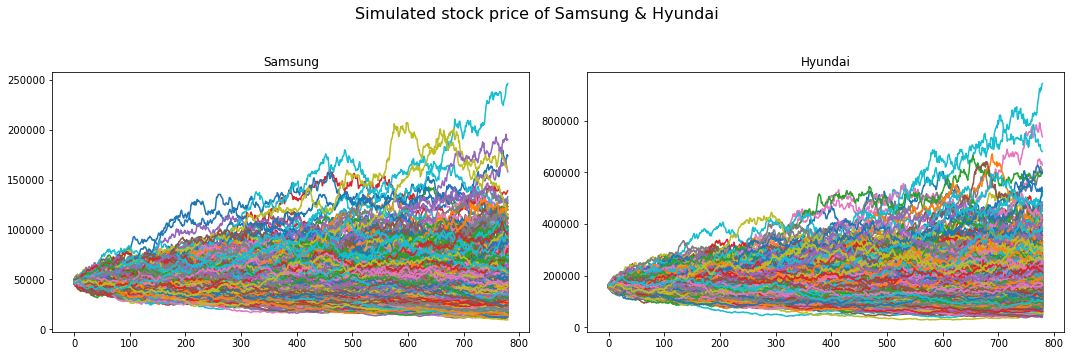

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 35535.31it/s]

valuation: 96740800

success events
  Condition  # Events
0   cond_01       596
1   cond_02        80
2   cond_03        47
3   cond_04        32
4   cond_05        27
5   cond_06         9
6   cond_07       105

failure events
  Condition  # Events
0   cond_08       104


In [33]:
df = pd.read_excel("../data/underlying_assets.xlsx", engine="openpyxl")

first_star_raw = df[df.Name == "삼성전자"].set_index("Date").loc[:, "Close"]
second_star_raw = df[df.Name == "현대차"].set_index("Date").loc[:, "Close"]

a_day_before_starting_date = "2017/06/29"
starting_date = "2017/06/30"
checking_date = ["2017/12/21", "2018/06/26", "2018/12/20", "2019/06/25", "2019/12/19", "2020/06/25"]
strike_price = np.array([0.87, 0.87, 0.87, 0.85, 0.85, 0.85])
coupon_rate = np.array([0.0475, 0.095, 0.1425, 0.19, 0.2375, 0.285])
knock_in_barrier = np.array([0.55])
riskfree_rate = 0.015

two_star_els = TwoStarELS(first_star_raw,
                          second_star_raw, 
                          a_day_before_starting_date, 
                          starting_date,
                          checking_date,
                          strike_price, 
                          coupon_rate, 
                          knock_in_barrier,
                          riskfree_rate
                         )

two_star_els.run(n_simulation=1000, preprocessing_verbose=False, simulation_verbose=True, firm_list=["Samsung", "Hyundai"])